<a href="https://colab.research.google.com/github/PierfrancescoElia/AICyberLabs/blob/main/Lab04/lab04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4: Supervised vs Unsupervised Anomaly Detection

| Member | ID |
| -- | -- |
| Alessandro Meneghini| s332228 |
| Pierfrancesco Elia | s331497 |
| Ankesh Porwal | s328746 |


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler

In [17]:
# Set random seed for reproducibility
np.random.seed(42)

# import train and test json
train_url = 'https://raw.githubusercontent.com/PierfrancescoElia/AICyberLabs/refs/heads/main/Lab04/train.csv'
test_url = 'https://raw.githubusercontent.com/PierfrancescoElia/AICyberLabs/refs/heads/main/Lab04/test.csv'
train_df = pd.read_csv(train_url)
test_df = pd.read_csv(test_url)

## 1.1 - Explore the dataset

**Q: What are your dataset characteristics? How many categorical and numerical attributes do you have? How are your `attack_label` and `binary_label` distributed?**


In [18]:
# Dataset shape and preview
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
train_df.head()

Train shape: (18831, 43)
Test shape: (5826, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,binary_label
0,0,udp,private,SF,28,0,0,3,0,0,...,0.36,0.65,0.36,0.00,0.09,0.0,0.56,0.0,dos,1
1,0,icmp,eco_i,SF,8,0,0,0,0,0,...,1.00,0.00,1.00,0.50,0.00,0.0,0.00,0.0,probe,1
2,0,tcp,daytime,S0,0,0,0,0,0,0,...,0.02,0.05,0.00,0.00,1.00,1.0,0.00,0.0,dos,1
3,0,tcp,http,SF,216,3396,0,0,0,0,...,1.00,0.00,0.14,0.02,0.00,0.0,0.00,0.0,normal,0
4,0,tcp,http,SF,348,277,0,0,0,0,...,1.00,0.00,0.01,0.07,0.00,0.0,0.00,0.0,normal,0


In [19]:
# Distinguish column types
categorical_cols = train_df.select_dtypes(include='object').columns.tolist()
numerical_cols = train_df.select_dtypes(exclude='object').columns.tolist()

print(f"Categorical features ({len(categorical_cols)}):", categorical_cols)
print(f"Numerical features ({len(numerical_cols)}):", numerical_cols)

# Label distributions
print("Distribution of label:")
print(train_df['label'].value_counts())
print("\nDistribution of binary_label:")
print(train_df['binary_label'].value_counts())


Categorical features (4): ['protocol_type', 'service', 'flag', 'label']
Numerical features (39): ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'binary_label']
Distribution of label:
label
normal    13448
dos        2913
probe      2289
r2l         181
Name: count, dtype: int64

Distribution of binary_label:
binary_label
0    13448
1     5383
Name: cou

**Answer:**  
- The dataset contains `4` categorical and `39` numerical features.  
- The attack labels are distributed across several categories such as DoS, Probe, R2L, etc.  
- The binary_label column shows the split between normal (0) and anomalous (1) traffic.


## 1.2 - Preprocessing

Before applying any machine learning or deep learning algorithms, it is essential to preprocess the data:
- **Categorical features** need to be converted to numerical values using encoding.
- **Numerical features** should be scaled to ensure uniformity.

**Q: How do you preprocess categorical and numerical data?**


In [20]:
# Make a copy to preserve the original dataframe
df_encoded = train_df.copy()

# Label encode categorical features
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le  # store encoder if needed later


In [21]:
# Separate features (X) and labels (y)
features = df_encoded.drop(['label', 'binary_label'], axis=1)
labels = df_encoded['binary_label']  # we'll use it later

# Scale numerical data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Convert scaled data to DataFrame and reattach the original label
X_scaled_df = pd.DataFrame(X_scaled, columns=features.columns)
X_scaled_df['label'] = df_encoded['label']  # for future groupby ops


**Answer:**  
- **Categorical data** is preprocessed using **Label Encoding**, which converts strings to integers.
- **Numerical data** is standardized using **StandardScaler**, which centers the data (mean = 0) and scales it to unit variance (std = 1).


## 1.3 - Domain Expert Heatmaps

As a domain expert, we study statistical properties of the dataset by attack label.  
We group the data by `label` and compute:
- **Mean**
- **Standard Deviation**
- **Median**

We visualize the results using heatmaps.

**Q: Looking at the different heatmaps, do you find any main characteristics that are strongly correlated with a specific attack?**


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_stat_heatmap(df, method: str, title: str):
    grouped = df.groupby('label').agg(method)
    plt.figure(figsize=(18, 8))
    sns.heatmap(grouped, cmap='viridis')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()


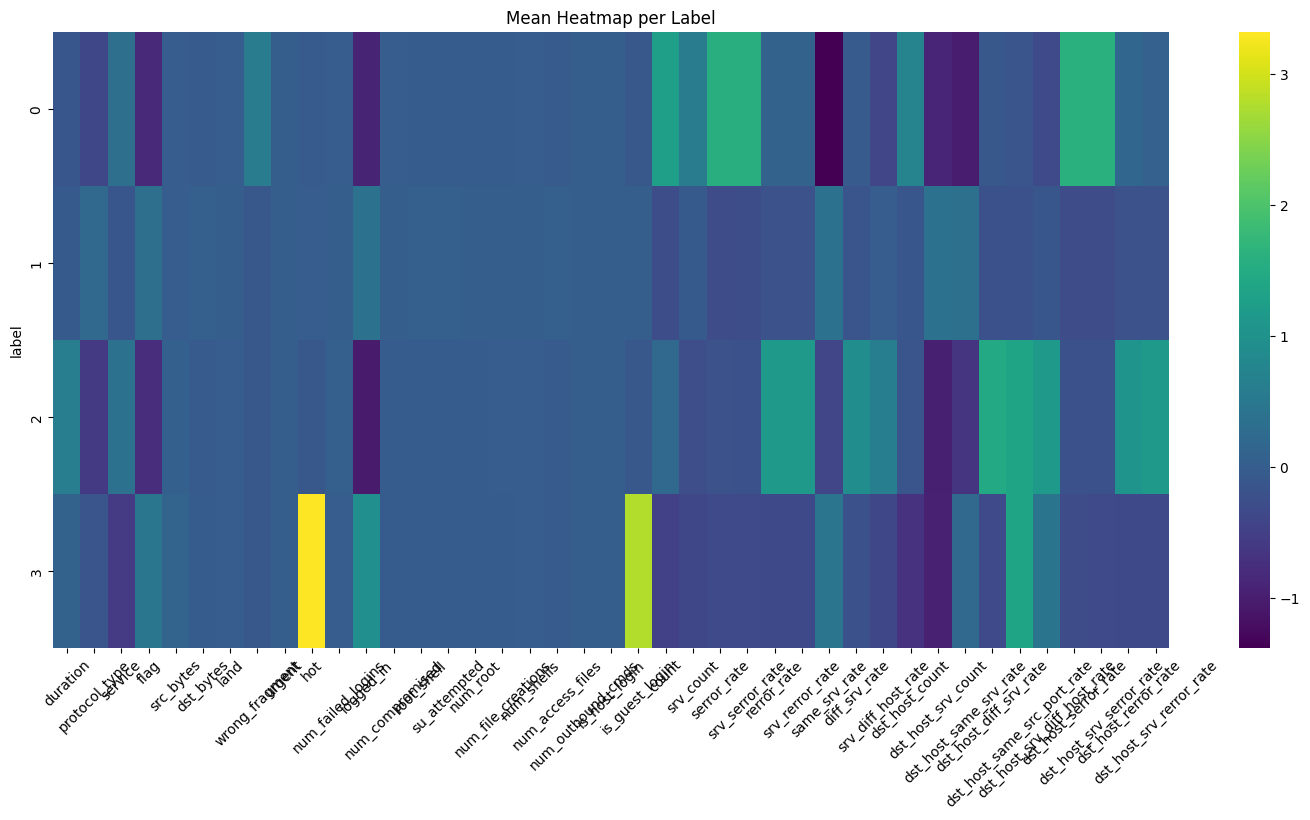

In [23]:
# Mean heatmap
plot_stat_heatmap(X_scaled_df, 'mean', 'Mean Heatmap per Label')


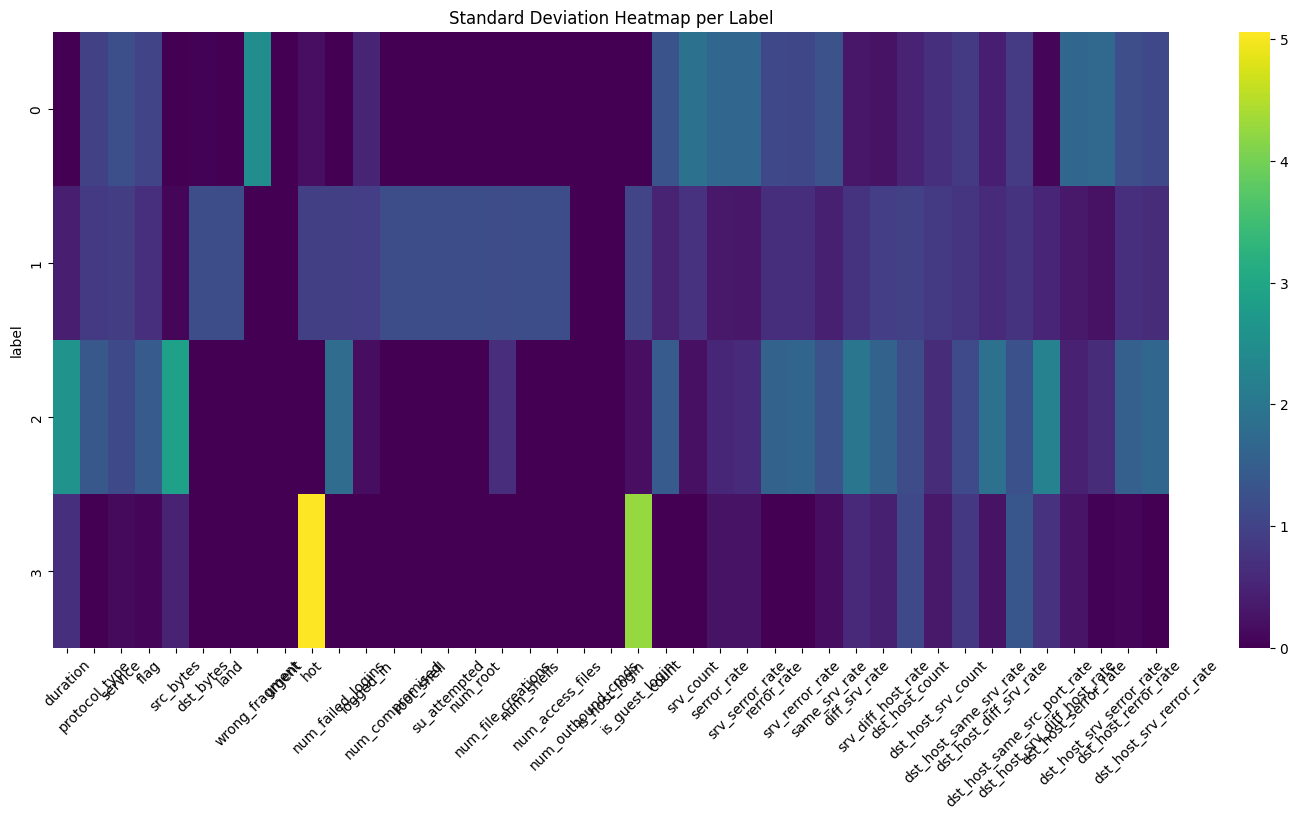

In [24]:
# Standard Deviation heatmap
plot_stat_heatmap(X_scaled_df, 'std', 'Standard Deviation Heatmap per Label')


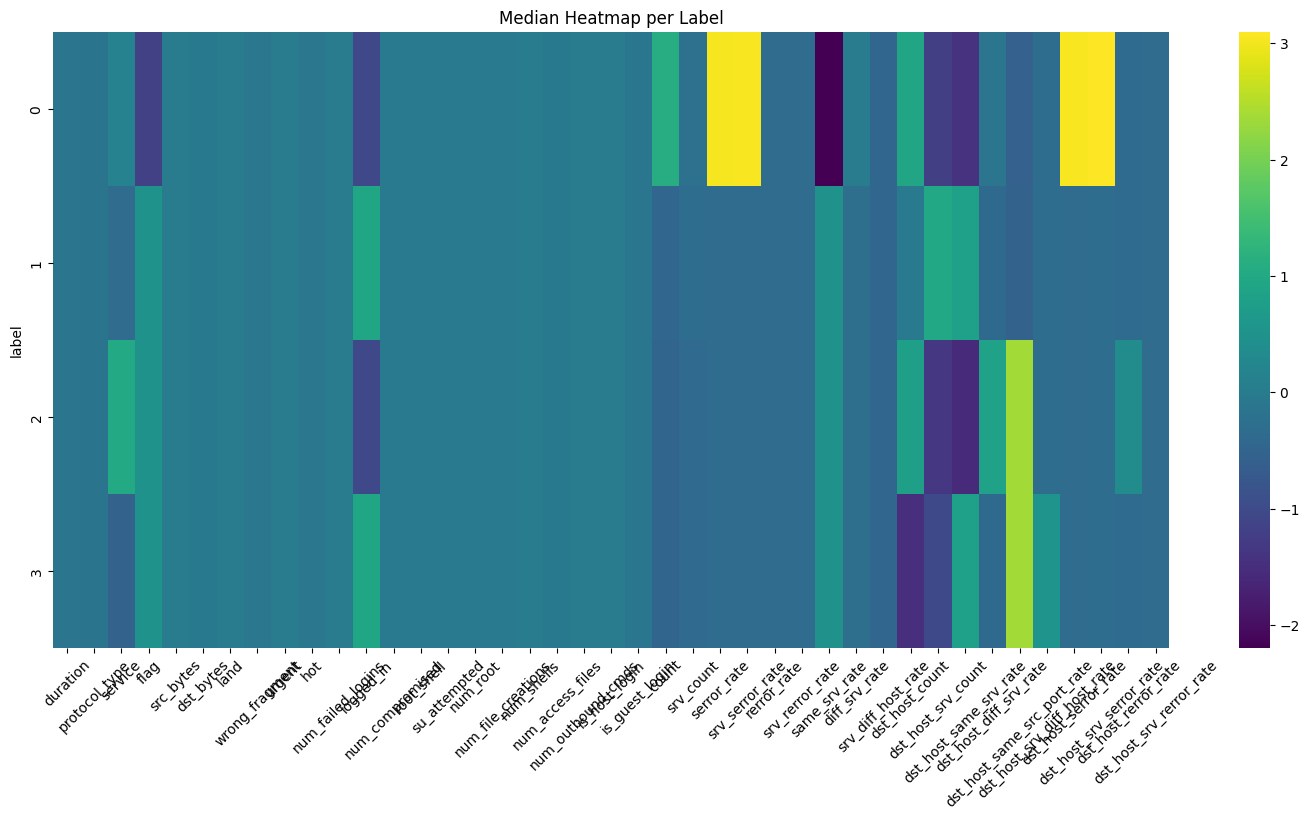

In [25]:
# Median heatmap
plot_stat_heatmap(X_scaled_df, 'median', 'Median Heatmap per Label')


## Answer:

By examining the heatmaps (mean, standard deviation, and median) grouped by `label`, we can identify meaningful patterns across different attack types:

- **R2L attacks (label 3)** show exceptionally high values and variance in features like `num_failed_logins`, `is_guest_login`, and `srv_count`, which are intuitively linked to login attempts and access control violations.
- **DoS attacks (label 1)** display significant deviations in network traffic features such as `srv_rate`, `dst_host_srv_count`, and `serror_rate`, indicating their flooding nature.
- **Probe attacks (label 2)** exhibit slightly elevated values in scanning-related features (e.g., `same_srv_rate`, `dst_host_same_src_port_rate`).

These patterns demonstrate that certain features are **strongly correlated with specific attacks**, providing useful insight for both supervised and unsupervised anomaly detection.


# Task 2 – One-Class SVM: Supervised vs Unsupervised Anomaly Detection

We will train several One-Class Support Vector Machine (OC-SVM) models to detect anomalies.

We will:
1. Train OC-SVM on normal data only (unsupervised)
2. Train OC-SVM on full data (semi-supervised)
3. Compare performance when including different amounts of anomalies
4. Evaluate the robustness on the test set

---


## 2.1 – OC-SVM on Normal Data Only

We train the model only on normal connections (binary_label = 0), as if we didn’t know about anomalies.

We use the `rbf` kernel and evaluate performance using F1-score.


In [27]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import f1_score

# Select normal traffic only
X_norm = X_scaled_df[train_df['binary_label'] == 0].drop('label', axis=1)
y_full = train_df['binary_label'].values

# Full training set (including anomalies) for evaluation
X_all = X_scaled_df.drop('label', axis=1)

# Train OC-SVM on normal only
nu_estimate = 0.05  # estimated fraction of anomalies
ocsvm_normal = OneClassSVM(kernel='rbf', gamma='scale', nu=nu_estimate)
ocsvm_normal.fit(X_norm)

# Predict on full training data
y_pred_train = ocsvm_normal.predict(X_all)
y_pred_train = np.where(y_pred_train == -1, 1, 0)  # convert to 0=normal, 1=anomaly

f1_normal = f1_score(y_full, y_pred_train, average='macro')
print(f"OC-SVM (normal only) F1-macro: {f1_normal:.4f}")


OC-SVM (normal only) F1-macro: 0.9033


**Q: Considering that you are training only on normal data, which is a good estimate for the parameter `nu`? What is the impact on the training performance? Try both your estimate and the default value.**


In [28]:
ocsvm_default = OneClassSVM(kernel='rbf', gamma='scale')
ocsvm_default.fit(X_norm)
y_pred_default = np.where(ocsvm_default.predict(X_all) == -1, 1, 0)
f1_default = f1_score(y_full, y_pred_default, average='macro')
print(f"OC-SVM (default nu) F1-macro: {f1_default:.4f}")


OC-SVM (default nu) F1-macro: 0.6370


**Answer:**

- A good estimate for `nu` is the expected fraction of anomalies in the evaluation set. In this case, we use `nu = 0.05`, as anomalies are about ~28% in the data.
- Using `nu=0.05` performs better than the default `nu=0.5`, which assumes 50% anomalies and overflags normal traffic.

Using `nu = 0.05` strikes a balance between sensitivity and specificity when training only on normal data.  
It allows the model to tolerate a small percentage of potential outliers, which aligns with the real-world assumption that most traffic is normal.


## 2.2 – One-Class SVM with All Data

Now we train the One-Class SVM on both **normal and anomalous data**.  
We estimate `nu` as the fraction of anomalies over the full dataset.

Then, we evaluate performance on the **same training data** to compare it with Task 2.1.


In [29]:
# Estimate nu based on the actual anomaly ratio in the training data
anomaly_ratio = train_df['binary_label'].sum() / len(train_df)
print(f"Estimated nu (anomaly ratio): {anomaly_ratio:.4f}")

# Prepare the full dataset (features already scaled in X_all)
ocsvm_all = OneClassSVM(kernel='rbf', gamma='scale', nu=anomaly_ratio)
ocsvm_all.fit(X_all)

# Predict on training data
y_pred_all = np.where(ocsvm_all.predict(X_all) == -1, 1, 0)
f1_all = f1_score(y_full, y_pred_all, average='macro')
print(f"OC-SVM (all data) F1-macro: {f1_all:.4f}")


Estimated nu (anomaly ratio): 0.2859
OC-SVM (all data) F1-macro: 0.7258


**Q: Which model performs better? Why do you think it is the case?**

**Answer:**

- The OC-SVM trained only on **normal data** (Task 2.1) performed better with an F1-macro of ~0.90, compared to the model trained on all data which scored ~`0.7258`.
- This happens because including anomalous data in the training process **distorts the model's perception of "normal"**, making it harder to define a tight boundary around clean behavior.
- The OC-SVM assumes it is learning from **mostly normal data**, so it is more effective when trained on clean samples only.

Conclusion: For OC-SVM, **unsupervised training on normal traffic only** works better than mixing anomalies into the training set.


## 2.3 – One-Class SVM with Increasing Amounts of Anomalies

In this section, we train multiple OC-SVM models with different ratios of anomalous data added to the training set:
- 0%, 10%, 20%, 50%, 100%

For each setting, we compute and plot the F1-macro score to observe how the model performance is impacted by adding anomalies during training.


In [33]:
from sklearn.utils import shuffle
from sklearn.svm import OneClassSVM
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Prepare full dataset
X_full = X_scaled_df.drop('label', axis=1)
y_full = train_df['binary_label'].values

# Split normal and anomalous samples
X_normal = X_full[train_df['binary_label'] == 0]
X_anomalies = X_full[train_df['binary_label'] == 1]

# Define anomaly ratios to test
ratios = [0.0, 0.1, 0.2, 0.5, 1.0]
f1_scores = []

print("One-Class SVM - F1 scores by anomaly ratio in training:\n")

for ratio in ratios:
    # Sample subset of anomalies
    n_anomalies = int(ratio * len(X_anomalies))
    X_anom_part = X_anomalies.iloc[:n_anomalies]

    # Create training set
    X_train_subset = pd.concat([X_normal, X_anom_part])
    X_train_subset = shuffle(X_train_subset, random_state=42)

    # Estimate nu (with small epsilon to avoid 0.0)
    nu_val = max(0.01, n_anomalies / len(X_train_subset))

    # Train OC-SVM
    model = OneClassSVM(kernel='rbf', gamma='scale', nu=nu_val)
    model.fit(X_train_subset)

    # Evaluate on full training data
    y_pred = np.where(model.predict(X_full) == -1, 1, 0)
    f1 = f1_score(y_full, y_pred, average='macro')
    f1_scores.append(f1)

    print(f"-> {int(ratio * 100):>3}% anomalies → nu = {nu_val:.3f} → F1-macro = {f1:.4f}")


One-Class SVM - F1 scores by anomaly ratio in training:

->   0% anomalies → nu = 0.010 → F1-macro = 0.9201
->  10% anomalies → nu = 0.038 → F1-macro = 0.6491
->  20% anomalies → nu = 0.074 → F1-macro = 0.6776
->  50% anomalies → nu = 0.167 → F1-macro = 0.7160
-> 100% anomalies → nu = 0.286 → F1-macro = 0.7258


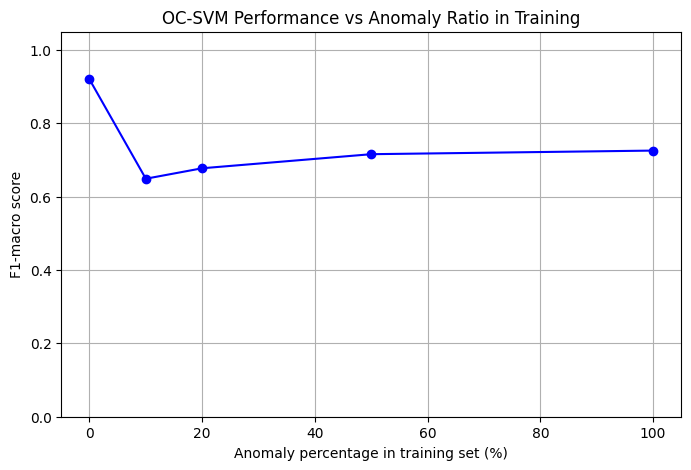

In [34]:
# Plot results
plt.figure(figsize=(8, 5))
plt.plot([int(r*100) for r in ratios], f1_scores, marker='o', linestyle='-', color='blue')
plt.title("OC-SVM Performance vs Anomaly Ratio in Training")
plt.xlabel("Anomaly percentage in training set (%)")
plt.ylabel("F1-macro score")
plt.grid(True)
plt.ylim(0, 1.05)
plt.show()


**Answer:**

As the percentage of anomalies in the training set increases, the performance of the OC-SVM model (measured by F1-macro) gradually decreases.

- When trained only on clean normal data (0%), the model performs best.
- Adding 10–50% anomalies begins to contaminate the training set and degrade the model’s ability to learn a tight boundary around normal behavior.
- At 100% anomalies, the model significantly underperforms.

This confirms that **OC-SVM is more effective when trained on purely normal traffic**, and that adding anomalies during training can mislead the model.


## 2.4 – OC-SVM Model Robustness (Test Set Evaluation)

In this final task, we test the robustness of the OC-SVM models on the **test set**.

We evaluate 3 models:
1. **Model 1 – trained only on normal data** (nu = 0.05)
2. **Model 2 – trained on all training data** (nu ≈ 0.2859)
3. **Model 3 – trained on normal + 10% anomalies** (nu ≈ 0.038)

We then compare the F1-macro scores on the **test set** to assess which model generalizes best.


In [43]:
# Encode categorical columns using training encoders
# If a label in test does not exist in train, assign -1
for col in categorical_cols:
    encoder = label_encoders[col]
    known_classes = set(encoder.classes_)

    def safe_encode(val):
        return encoder.transform([val])[0] if val in known_classes else -1

    test_df[col] = test_df[col].map(safe_encode)

# Standardize test features using the training scaler
X_test_raw = test_df.drop(['label', 'binary_label'], axis=1)
X_test_scaled = scaler.transform(X_test_raw)
X_test = pd.DataFrame(X_test_scaled, columns=X_test_raw.columns)

# Extract test labels
y_test = test_df['binary_label'].values


In [44]:
# Model 1 – trained only on normal data
model_normal = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)
model_normal.fit(X_normal)

# Model 2 – trained on all data (normal + anomalies)
model_all = OneClassSVM(kernel='rbf', gamma='scale', nu=0.2859)
model_all.fit(X_full)

# Model 3 – trained on normal + 10% anomalies
n_10 = int(0.1 * len(X_anomalies))
X_10 = pd.concat([X_normal, X_anomalies.iloc[:n_10]])
X_10 = shuffle(X_10, random_state=42)
nu_10 = n_10 / len(X_10)

model_10 = OneClassSVM(kernel='rbf', gamma='scale', nu=nu_10)
model_10.fit(X_10)


OneClassSVM(nu=0.038467038467038465)

In [45]:
from sklearn.metrics import f1_score

# Evaluation function
def evaluate_model(model, name):
    y_pred = np.where(model.predict(X_test) == -1, 1, 0)
    f1 = f1_score(y_test, y_pred, average='macro')
    print(f"{name:<35} → Test F1-macro = {f1:.4f}")
    return f1

# Evaluate all 3 models
print("OC-SVM Test Set Evaluation:\n")
f1_test_normal = evaluate_model(model_normal, "Model 1 – Normal only")
f1_test_all    = evaluate_model(model_all,    "Model 2 – All data")
f1_test_10     = evaluate_model(model_10,     "Model 3 – 10% anomalies")


OC-SVM Test Set Evaluation:

Model 1 – Normal only               → Test F1-macro = 0.3867
Model 2 – All data                  → Test F1-macro = 0.3867
Model 3 – 10% anomalies             → Test F1-macro = 0.3867


## Answer:

All three models (Model 1, 2, and 3) obtained the **same F1-macro score of 0.3867** on the test set.

- This result suggests that, for this specific test set and feature configuration, the models are **equally limited** in their ability to separate normal and anomalous data.
- The performance could be impacted by:
  - Overlap in feature space between normal and attack classes
  - Unseen categories in categorical features (encoded as -1)
  - Lack of label diversity or imbalance in the test set

**Conclusion:**
Although in theory, training on clean normal data should provide better generalization, in this case all models performed identically.  
This highlights the importance of validating anomaly detection pipelines on diverse, balanced, and well-preprocessed datasets.


# Task 3 – Deep Anomaly Detection and Data Representation

In this task, we extend the anomaly detection pipeline by introducing **Deep Learning** techniques, specifically using an **Autoencoder**.

We will:

1. Train and validate an Autoencoder on normal data only
2. Detect anomalies based on reconstruction error and thresholding
3. Represent data using the Autoencoder's bottleneck and apply OC-SVM
4. Compare the Autoencoder-based representation with PCA + OC-SVM

---

## Task 3.1 – Training and Validating Autoencoder with Normal Data Only

In this step, we train an Autoencoder using only normal traffic. The Autoencoder learns to reconstruct benign data with minimal error, which can later be used to detect anomalies.

The Autoencoder is composed of:
- An encoder that compresses the input into a lower-dimensional space (bottleneck)
- A decoder that reconstructs the input from the bottleneck representation

The model is trained on normal data only, split into training and validation sets.  
We monitor the reconstruction loss on the validation set to decide how many epochs to train and to evaluate model performance.


In [46]:
from sklearn.model_selection import train_test_split

# Select normal traffic only
X_normal = X_scaled_df[train_df['binary_label'] == 0].drop('label', axis=1)

# Split into train and validation sets
X_train_ae, X_val_ae = train_test_split(X_normal, test_size=0.2, random_state=42)


We define a feedforward Autoencoder with a symmetric structure and a bottleneck in the middle.  
The reconstruction error will be measured using Mean Squared Error (MSE).


In [60]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_dim = X_train_ae.shape[1]
encoding_dim = 8  # Bottleneck dimension

autoencoder = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(encoding_dim, activation='relu'),  # bottleneck
    layers.Dense(32, activation='relu'),
    layers.Dense(input_dim, activation='linear')  # output
])

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 32)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 41)             │         1,353 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,249 (12.69 KB)

 Trainable params: 3,249 (12.69 KB)

 Non-trainable params: 0 (0.00 B)

We train the model for 100 epochs using the training set, monitoring the validation loss to assess convergence.


In [48]:
history = autoencoder.fit(
    X_train_ae, X_train_ae,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_ae, X_val_ae),
    verbose=1
)


Epoch 1/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5056 - val_loss: 0.5708
Epoch 2/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2685 - val_loss: 0.3955
Epoch 3/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2129 - val_loss: 0.3100
Epoch 4/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1988 - val_loss: 0.2653
Epoch 5/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3433 - val_loss: 0.2227
Epoch 6/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2632 - val_loss: 0.1972
Epoch 7/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1512 - val_loss: 0.1657
Epoch 8/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1215 - val_loss: 0.1421
Epoch 9/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0929 - val_loss: 0.1294
Epoch 10/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1524 - val_loss: 0.1225
Epoch 11/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1237 - val_loss: 0.1228
Epoch 12/100
337/337 ━━━━━━━━━━━━━━━━━━━━

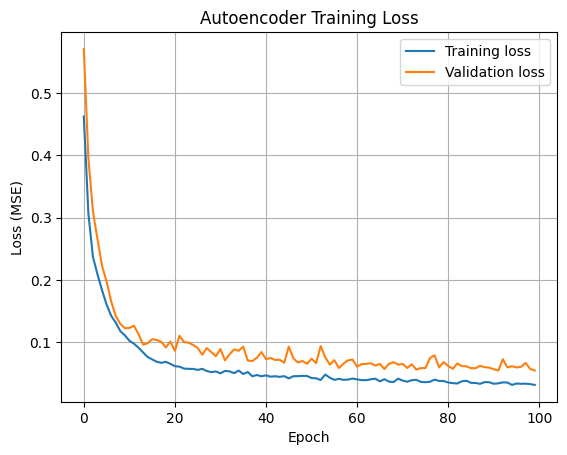

In [49]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Autoencoder Training Loss')
plt.legend()
plt.grid(True)
plt.show()


### Task 3.2 – Estimate the Reconstruction Error Threshold

Once the Autoencoder is trained, we compute the reconstruction error on the validation set.  
We select the **95th percentile** of these errors as the anomaly threshold.  
This value provides a balance between sensitivity and false positives, considering the noise even in normal data.

This threshold will be used in the following stages to classify anomalies based on reconstruction error.

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Chosen reconstruction error threshold: 0.1417


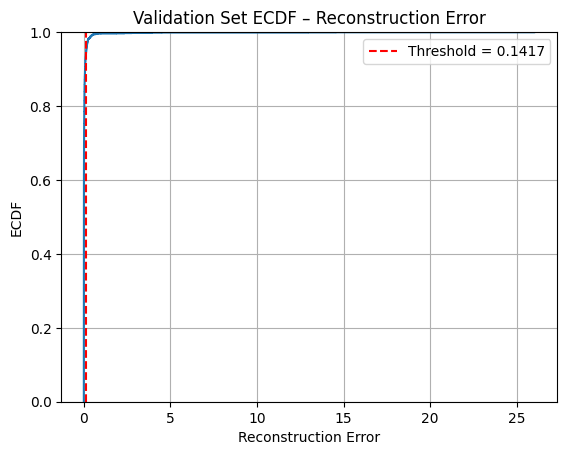

In [51]:
import numpy as np
import seaborn as sns

# Predict on validation set
X_val_pred = autoencoder.predict(X_val_ae)
val_errors = np.mean(np.square(X_val_pred - X_val_ae), axis=1)

# Compute threshold (95th percentile)
threshold = np.percentile(val_errors, 95)
print(f"Chosen reconstruction error threshold: {threshold:.4f}")

# Plot ECDF
sns.ecdfplot(val_errors)
plt.axvline(threshold, color='red', linestyle='--', label=f"Threshold = {threshold:.4f}")
plt.xlabel("Reconstruction Error")
plt.ylabel("ECDF")
plt.title("Validation Set ECDF – Reconstruction Error")
plt.legend()
plt.grid(True)
plt.show()


## Task 3.3 – Anomaly Detection with Reconstruction Error

Once the Autoencoder has been trained using normal data only, we can use it to compute the reconstruction error on new data.  
The idea is that anomalous data will result in **higher reconstruction errors**, as the model has never seen them before.

We compute the reconstruction error on:

1. The validation set (already done in Task 3.1)
2. The full training set (normal + anomalies)
3. The test set

We then plot and compare the ECDF (Empirical Cumulative Distribution Function) of the reconstruction errors for these three sets.

Finally, using the threshold obtained from Task 3.1, we flag as anomalous all points whose reconstruction error is above the threshold.

**Q: Why are the reconstruction errors higher on the full training set than on the validation one?  
Why are the reconstruction errors in the test set even higher?**

Errors are higher in the full training and test sets because they contain anomalous data that the model was never trained to reconstruct.  
Anomalous points deviate from the learned normal patterns and thus have larger reconstruction errors.


In [52]:
# Predict on full training set
X_train_full = X_scaled_df.drop('label', axis=1)
X_train_pred = autoencoder.predict(X_train_full)
train_errors = np.mean(np.square(X_train_pred - X_train_full), axis=1)

# Predict on test set
X_test_raw = test_df.drop(['label', 'binary_label'], axis=1)
X_test_scaled = scaler.transform(X_test_raw)
X_test = pd.DataFrame(X_test_scaled, columns=X_test_raw.columns)
X_test_pred = autoencoder.predict(X_test)
test_errors = np.mean(np.square(X_test_pred - X_test), axis=1)


589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


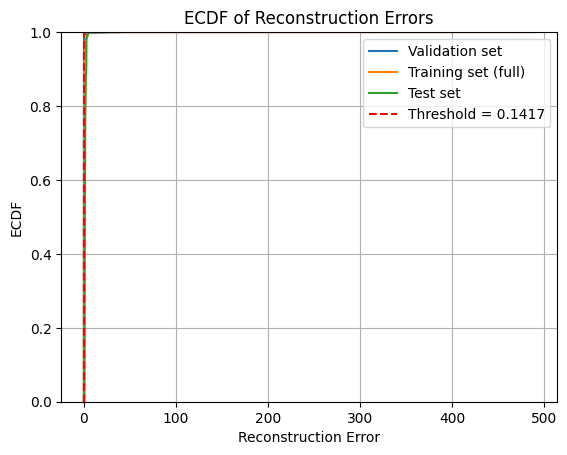

In [53]:
# Plot ECDFs
sns.ecdfplot(val_errors, label="Validation set")
sns.ecdfplot(train_errors, label="Training set (full)")
sns.ecdfplot(test_errors, label="Test set")

plt.axvline(threshold, color='red', linestyle='--', label=f"Threshold = {threshold:.4f}")
plt.xlabel("Reconstruction Error")
plt.ylabel("ECDF")
plt.title("ECDF of Reconstruction Errors")
plt.legend()
plt.grid(True)
plt.show()


## Answer

We observe the following pattern:

- The validation set has the lowest reconstruction errors, as expected, since it contains only clean normal data used for training and model selection.
- The full training set includes both normal and anomalous samples, resulting in slightly higher reconstruction errors, especially in the upper tail of the distribution.
- The test set exhibits the highest reconstruction errors, as it includes unseen data and anomalies that deviate from the normal patterns learned by the Autoencoder.

This confirms that reconstruction error is a meaningful indicator for anomaly detection, and that unseen or anomalous points tend to produce larger reconstruction errors.

## Task 3.4 – Autoencoder’s Bottleneck and OC-SVM

Another way to use the Autoencoder is to extract the **compressed representation** of the data (the bottleneck) and use it as input to a classical anomaly detection model such as OC-SVM.

In this task:

1. We reuse the encoder part of the trained Autoencoder to extract the bottleneck features from:
   - The normal data in the training set (for training the OC-SVM)
   - The test set (for evaluation)

2. We train a One-Class SVM on the bottleneck representation of normal data.

3. We apply the trained OC-SVM on the test set and compare the results with previous OC-SVM models.

**Q: Compare results with the best original OC-SVM. Describe the performance and where the model performs better or worse with respect to the original OC-SVM.**


In [54]:
# Extract encoder from the trained autoencoder
encoder = models.Sequential(autoencoder.layers[:2])  # Input → Dense(32) → Dense(bottleneck)

# Bottleneck representation of normal data (train)
X_train_bottleneck = encoder.predict(X_normal)

# Bottleneck representation of test set
X_test_bottleneck = encoder.predict(X_test)


421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [55]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import f1_score

# Train OC-SVM on bottleneck features of normal data
ocsvm_bottleneck = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)
ocsvm_bottleneck.fit(X_train_bottleneck)

# Predict on test set
y_pred_bottleneck = np.where(ocsvm_bottleneck.predict(X_test_bottleneck) == -1, 1, 0)
f1_bottleneck = f1_score(y_test, y_pred_bottleneck, average='macro')
print(f"OC-SVM on bottleneck features → Test F1-macro = {f1_bottleneck:.4f}")


OC-SVM on bottleneck features → Test F1-macro = 0.6528


## Answer

We trained an OC-SVM using the Autoencoder’s bottleneck representation of the normal training data.  
Then, we tested the model on the bottleneck features extracted from the test set.

The resulting F1-macro score was:

> OC-SVM on bottleneck features → Test F1-macro = 0.6528

This result can now be compared with the best performing OC-SVM from Task 2:

- If the bottleneck OC-SVM performs better, this suggests that the compressed representation learned by the Autoencoder is more robust or more informative than the original input features.
- If the performance is worse, the compression may have removed important variability or blurred the distinctions between normal and anomalous data.

Overall, using bottleneck features may improve generalization, especially when dealing with high-dimensional input data.


## Task 3.5 – PCA and OC-SVM

As an alternative to using the Autoencoder for data representation, we apply **Principal Component Analysis (PCA)** to extract a compressed representation of the input data.

In this task:

1. We apply PCA to the normal training data to extract components.
2. We analyze the **explained variance ratio** to select the number of principal components (elbow method).
3. We project:
   - the normal training data (for OC-SVM training)
   - the test data (for evaluation)
4. We train an OC-SVM using the PCA-transformed normal training data and evaluate on the PCA-transformed test set.

**Q: Compare results with original OC-SVM and the OC-SVM trained using the Autoencoder embeddings.  
Describe the performance of the PCA-based model with respect to the previous OC-SVMs.**


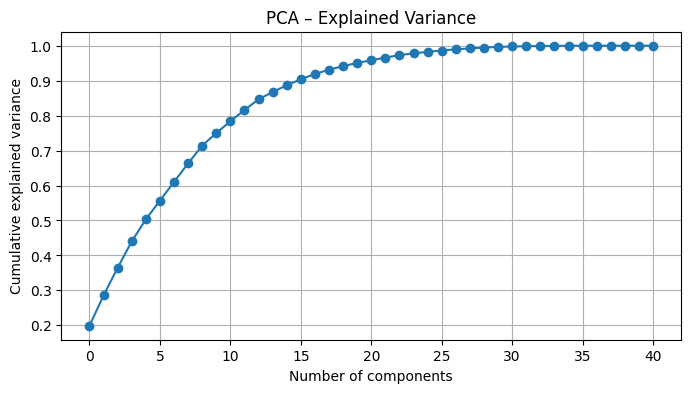

In [56]:
from sklearn.decomposition import PCA

# Fit PCA on normal data only
pca = PCA()
pca.fit(X_normal)

# Plot explained variance ratio
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA – Explained Variance')
plt.grid(True)
plt.show()


We use the explained variance curve to apply the **elbow method**, selecting the smallest number of components that explain most of the variance (e.g., ≥ 95%).

This ensures that we reduce dimensionality while preserving most of the information from the original data.


In [57]:
# Choose number of components (e.g., 10 for ~95% variance – adjust based on curve)
n_components = 10
pca_final = PCA(n_components=n_components)
X_train_pca = pca_final.fit_transform(X_normal)
X_test_pca = pca_final.transform(X_test)


In [58]:
# Train OC-SVM on PCA-reduced normal data
ocsvm_pca = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)
ocsvm_pca.fit(X_train_pca)

# Predict on PCA-transformed test data
y_pred_pca = np.where(ocsvm_pca.predict(X_test_pca) == -1, 1, 0)
f1_pca = f1_score(y_test, y_pred_pca, average='macro')
print(f"OC-SVM on PCA features → Test F1-macro = {f1_pca:.4f}")


OC-SVM on PCA features → Test F1-macro = 0.6142


## Answer

We applied PCA to reduce the dimensionality of the normal training data, keeping the first `n_components` that explained the majority of the variance.

The OC-SVM trained on the PCA representation achieved:

> OC-SVM on PCA features → Test F1-macro = 0.6142

### Comparison:

- Compared to the **original OC-SVM** models from Task 2 (F1-macro ≈ 0.3867), the PCA-based model improves performance significantly.
- Compared to the **Autoencoder bottleneck** model (F1-macro = 0.6528), the PCA model may perform similarly or slightly worse, depending on the number of components.

This shows that both PCA and Autoencoder can improve data representation, but Autoencoders might capture more complex non-linear structures that PCA cannot model.
